## Spatially resolved analysis of mouse hypothalamus by Bulk2Space

In this tutorial, we will show you an application of Bulk2Space to spatially deconvolve bulk transcriptome data derived from the hypothalamus region of the mouse brain using our in-house developed multiplexed barcoding RNA-seq method, termed Spatial-seq, to explain the spatial distribution of single cells and gene expression.
The processed [mouse hypothalamus bulk-seq data (GSE192999)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE192999) by Liao et.al., the [mouse hypothalamus scRNA-seq data (GSE113576)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE113576) and [MERFISH data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.8t8s248) by Moffitt et.al. can be found [here](https://drive.google.com/file/d/1ZGstNzVX-YxofrPP8ZVmr0Zu4nd_O_bZ/view?usp=sharing).

### Import modules

In [1]:
import scanpy
import pandas as pd
import numpy as np
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import bulk2space
from bulk2space import Bulk2Space
model = Bulk2Space()

### Decompose bulk-seq data into scRNA-seq data

In [2]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate(
    input_bulk_path='tutorial/data/hypothalamus/lcm_bulk.csv',
    input_sc_data_path='tutorial/data/hypothalamus/lcm_sc_dt.csv',
    input_sc_meta_path='tutorial/data/hypothalamus/lcm_sc_ct.csv',
    input_st_data_path='tutorial/data/hypothalamus/lcm_st_data.csv',
    input_st_meta_path='tutorial/data/hypothalamus/lcm_st_meta.csv',
    ratio_num=1,
    top_marker_num=500,
    gpu=0,
    batch_size=512,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='tutorial/data/hypothalamus/predata/save_model',
    vae_save_name='hypothalamus_vae',
    generate_save_dir='tutorial/data/hypothalamus/predata/output',
    generate_save_name='hypothalamus')

loading data......
load data done!
begin vae training...


Train Epoch: 3499: 100%|█| 3500/3500 [3:10:25<00:00,  3.26s/it, loss=5.9164, min_loss=5.9127]


min loss = 5.9127243384718895
vae training done!


generating:   0%|                                                | 0/30371.0 [00:00<?, ?it/s]

save trained vae in tutorial/data/hypothalamus/predata/save_model/hypothalamus_vae.pth.
generating....


generating: 100%|█████████████████████████████████| 30371/30371.0 [00:02<00:00, 15009.19it/s]


generated done!
saving to tutorial/data/hypothalamus/predata/output/hypothalamus_sc_celltype.csv and tutorial/data/hypothalamus/predata/output/hypothalamus_sc_data.csv.


### Plot cell type proportion of generated scRNA-seq data

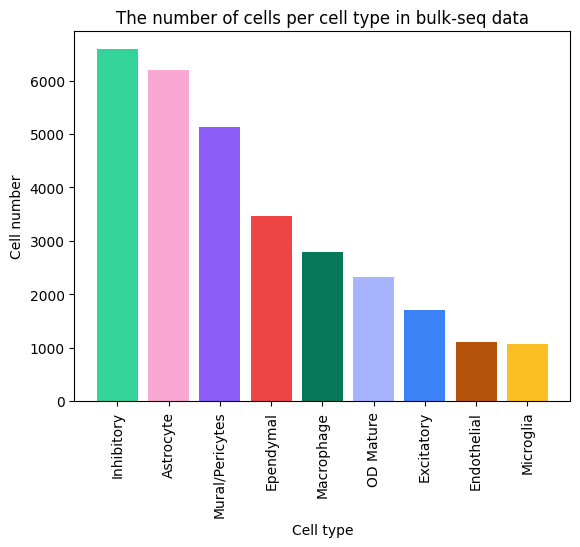

In [3]:
# The number of cells per cell type in deconvoluted bulk-seq data
ct_stat = pd.DataFrame(generate_sc_meta['Cell_type'].value_counts())
ct_name = list(ct_stat.index)
ct_num = list(ct_stat['Cell_type'])
color = ["#34D399", "#F9A8D4", '#8B5CF6', "#EF4444", '#047857', '#A5B4FC', "#3B82F6", '#B45309', '#FBBF24']
plt.bar(ct_name, ct_num, color=color)
plt.xticks(ct_name, ct_name, rotation=90)
plt.title("The number of cells per cell type in bulk-seq data")
plt.xlabel("Cell type")
plt.ylabel("Cell number")
plt.show()

### Calculate marker genes expression correlation between scRNA-seq reference and generated scRNA-seq data

loading data......
load data done!


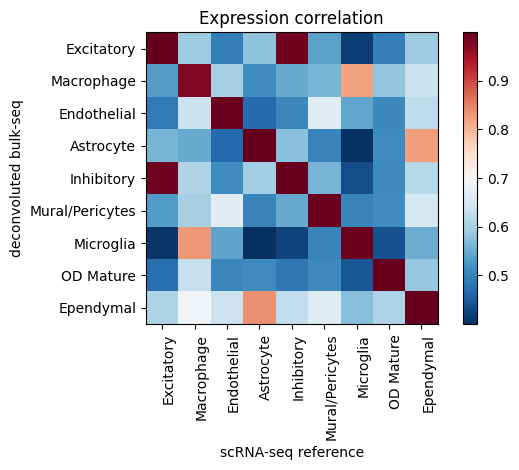

In [4]:
# load input sc data
input_data = bulk2space.utils.load_data(
    input_bulk_path='tutorial/data/hypothalamus/lcm_bulk.csv',
    input_sc_data_path='tutorial/data/hypothalamus/lcm_sc_dt.csv',
    input_sc_meta_path='tutorial/data/hypothalamus/lcm_sc_ct.csv',
    input_st_data_path='tutorial/data/hypothalamus/lcm_st_data.csv',
    input_st_meta_path='tutorial/data/hypothalamus/lcm_st_meta.csv'
)

# Calculate 200 marker genes of each cell type
sc = scanpy.AnnData(input_data['input_sc_data'].T)
sc.obs = input_data['input_sc_meta'][['Cell_type']]
scanpy.tl.rank_genes_groups(sc, 'Cell_type', method='wilcoxon')
marker_df = pd.DataFrame(sc.uns['rank_genes_groups']['names']).head(200)
marker = list(np.unique(np.ravel(np.array(marker_df))))

# the mean expression of 200 marker genes of input sc data
sc_marker = input_data['input_sc_data'].loc[marker, :].T
sc_marker['Cell_type'] = input_data['input_sc_meta']['Cell_type']
sc_marker_mean = sc_marker.groupby('Cell_type')[marker].mean()

# the mean expression of 200 marker genes of deconvoluted bulk-seq data
generate_sc_meta.index = list(generate_sc_meta['Cell'])
generate_sc_data_new = generate_sc_data.T
generate_sc_data_new['Cell_type'] = generate_sc_meta['Cell_type']
generate_sc_marker_mean = generate_sc_data_new.groupby('Cell_type')[marker].mean()

intersect_cell = list(set(sc_marker_mean.index).intersection(set(generate_sc_marker_mean.index)))
generate_sc_marker_mean= generate_sc_marker_mean.loc[intersect_cell]
sc_marker_mean= sc_marker_mean.loc[intersect_cell]

# calculate correlation
sc_marker_mean = sc_marker_mean.T
generate_sc_marker_mean = generate_sc_marker_mean.T

coeffmat = np.zeros((sc_marker_mean.shape[1], generate_sc_marker_mean.shape[1]))
for i in range(sc_marker_mean.shape[1]):    
    for j in range(generate_sc_marker_mean.shape[1]):        
        corrtest = pearsonr(sc_marker_mean[sc_marker_mean.columns[i]], 
                            generate_sc_marker_mean[generate_sc_marker_mean.columns[j]])  
        coeffmat[i,j] = corrtest[0]
        
rf_ct = list(sc_marker_mean.columns)
generate_ct = list(generate_sc_marker_mean.columns)

# plot
fig, ax = plt.subplots()
im = ax.imshow(coeffmat, cmap='RdBu_r')
ax.set_xticks(np.arange(len(rf_ct)))
ax.set_xticklabels(rf_ct)
ax.set_yticks(np.arange(len(generate_ct)))
ax.set_yticklabels(generate_ct)
plt.xlabel("scRNA-seq reference")
plt.ylabel("deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("Expression correlation")
fig.tight_layout()
plt.show()

### Map image-based spatial transcriptomics data into spatially resolved single-cell transcriptomics data

Here we applied MERFISH data as spatial reference.

In [5]:
df_meta, df_data = model.spatial_mapping(
    generate_sc_meta,
    generate_sc_data,
    input_st_data_path='tutorial/data/hypothalamus/lcm_st_data.csv',
    input_st_meta_path='tutorial/data/hypothalamus/lcm_st_meta.csv')

start to process image-based st data...
saving to output/meta_map.csv and output/data_map.csv


Bulk2Space successfully predicted whole gene expression profiles of MERFISH data.

In [6]:
input_data['input_st_data'].shape

(155, 6154)

In [7]:
df_data.shape

(17757, 6154)

### Plot spatial mapping result with single cell resolution

The spatial distribution of distinct cells in Bulk2Space results showed significant spatial patterns.

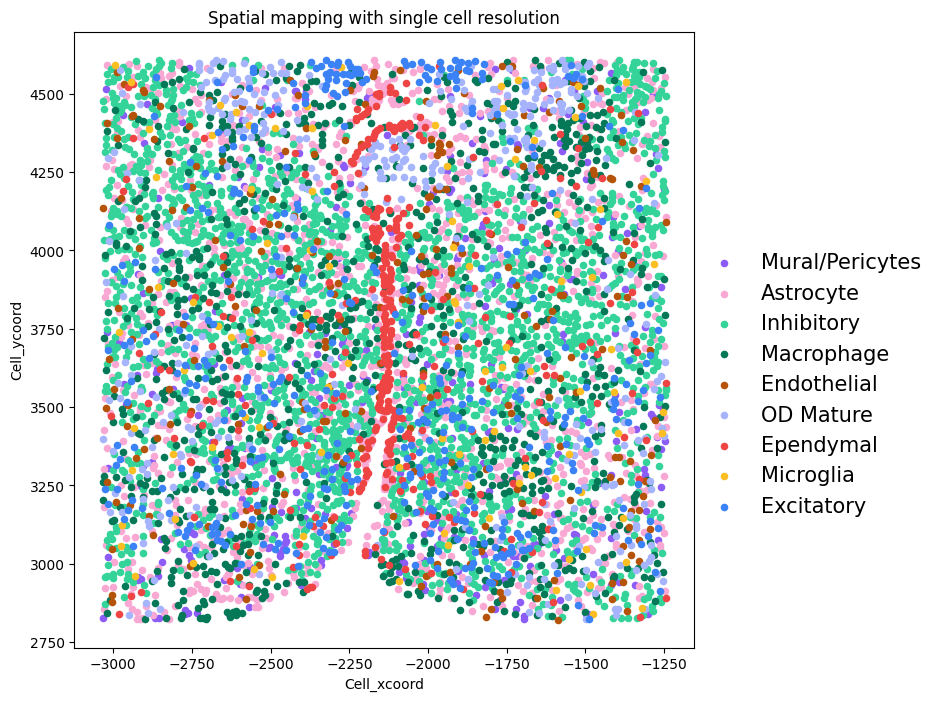

In [9]:
# Spatial mapping with single cell resolution
ct_type = list(df_meta['Cell_type'].unique())
color = ["#8B5CF6", "#F9A8D4", '#34D399', "#047857", '#B45309', '#A5B4FC', "#EF4444", '#FBBF24', '#3B82F6']

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(ct_type)):
    ax.scatter(df_meta.loc[df_meta.Cell_type == ct_type[i], 'xcoord'],
               df_meta.loc[df_meta.Cell_type == ct_type[i], 'ycoord'],
               color = color[i], label = ct_type[i], s = 20)


plt.title("Spatial mapping with single cell resolution")
plt.xlabel("Cell_xcoord")
plt.ylabel("Cell_ycoord")
plt.legend(bbox_to_anchor=(1, 0.2), loc=3, borderaxespad=0, frameon=False, fontsize=15)
plt.show()  

### Compare the spatial expression patterns of targeted genes between Bulk2Space-predicted and MERFISH-measured

We firstly investigate the Bulk2Space predicted and MERFISH measured spatial expression of targeted genes, and the results showed that the spatial expression patterns were consistant with each other.

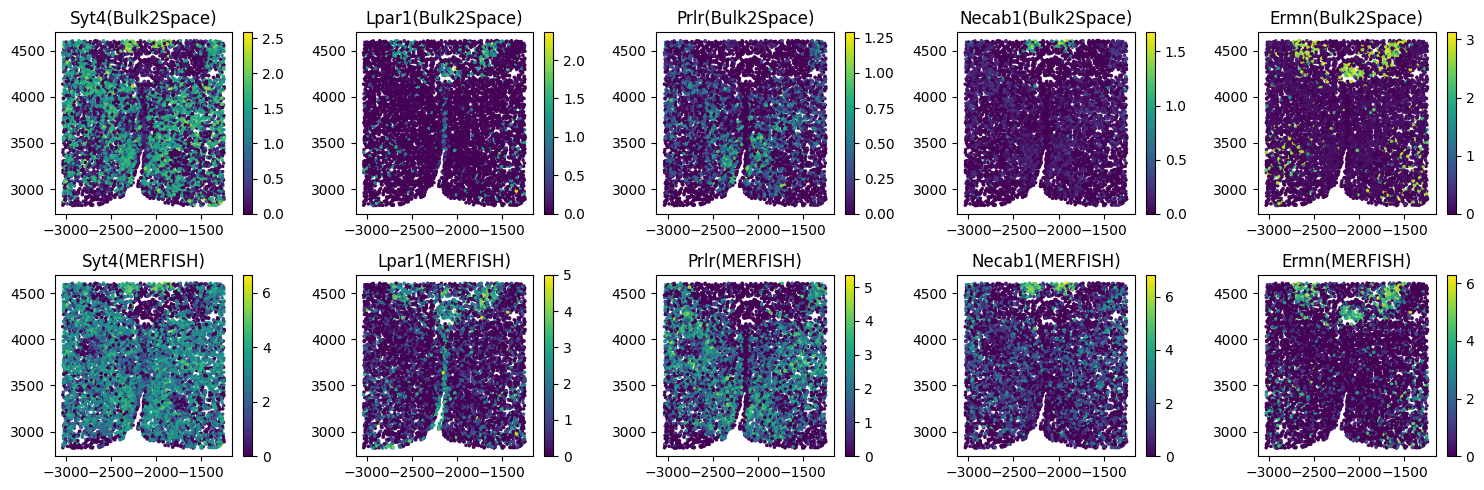

In [10]:
# The Bulk2Space predicted and MERFISH measured spatial expression of targeted genes
# gene expression (Bulk2Space)
plot1 = df_meta
plot1.index = list(plot1['Cell'])
gene = ['Syt4', 'Lpar1', 'Prlr', 'Necab1', 'Ermn']
plot1[gene] = df_data.T[gene]
xcoord = np.array(plot1['xcoord'])
ycoord = np.array(plot1['ycoord'])
gene1 = np.array(plot1['Syt4'])
gene2 = np.array(plot1['Lpar1'])
gene3 = np.array(plot1['Prlr'])
gene4 = np.array(plot1['Necab1'])
gene5 = np.array(plot1['Ermn'])

# gene expression (MERFISH)
plot2 = input_data['input_st_meta']
plot2.index = list(plot2['Cell'])
gene = ['Syt4', 'Lpar1', 'Prlr', 'Necab1', 'Ermn']
plot2[gene] = np.log2(input_data['input_st_data'] + 1).T[gene]
xcoord = np.array(plot2['xcoord'])
ycoord = np.array(plot2['ycoord'])
gene6 = np.array(plot2['Syt4'])
gene7 = np.array(plot2['Lpar1'])
gene8 = np.array(plot2['Prlr'])
gene9 = np.array(plot2['Necab1'])
gene10 = np.array(plot2['Ermn'])

# plot
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

p1 = axs[0, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene1)
fig.colorbar(p1, ax=axs[0, 0])
axs[0, 0].set_title('Syt4(Bulk2Space)')

p2 = axs[0, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene2)
fig.colorbar(p2, ax=axs[0, 1])
axs[0, 1].set_title('Lpar1(Bulk2Space)')

p3 = axs[0, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene3)
fig.colorbar(p3, ax=axs[0, 2])
axs[0, 2].set_title('Prlr(Bulk2Space)')

p4 = axs[0, 3].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene4)
fig.colorbar(p4, ax=axs[0, 3])
axs[0, 3].set_title('Necab1(Bulk2Space)')

p5 = axs[0, 4].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene5)
fig.colorbar(p5, ax=axs[0, 4])
axs[0, 4].set_title('Ermn(Bulk2Space)')


p6 = axs[1, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene6)
fig.colorbar(p6, ax=axs[1, 0])
axs[1, 0].set_title('Syt4(MERFISH)')

p7 = axs[1, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene7)
fig.colorbar(p7, ax=axs[1, 1])
axs[1, 1].set_title('Lpar1(MERFISH)')

p8 = axs[1, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene8)
fig.colorbar(p8, ax=axs[1, 2])
axs[1, 2].set_title('Prlr(MERFISH)')

p9 = axs[1, 3].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene9)
fig.colorbar(p9, ax=axs[1, 3])
axs[1, 3].set_title('Necab1(MERFISH)')

p10 = axs[1, 4].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene10)
fig.colorbar(p10, ax=axs[1, 4])
axs[1, 4].set_title('Ermn(MERFISH)')


plt.tight_layout()
plt.show()

### Investigate the spatial expression patterns of novel marker genes

Further more, Bulk2Space could also predict spatial expression patterns of novel marker genes for different cell types.

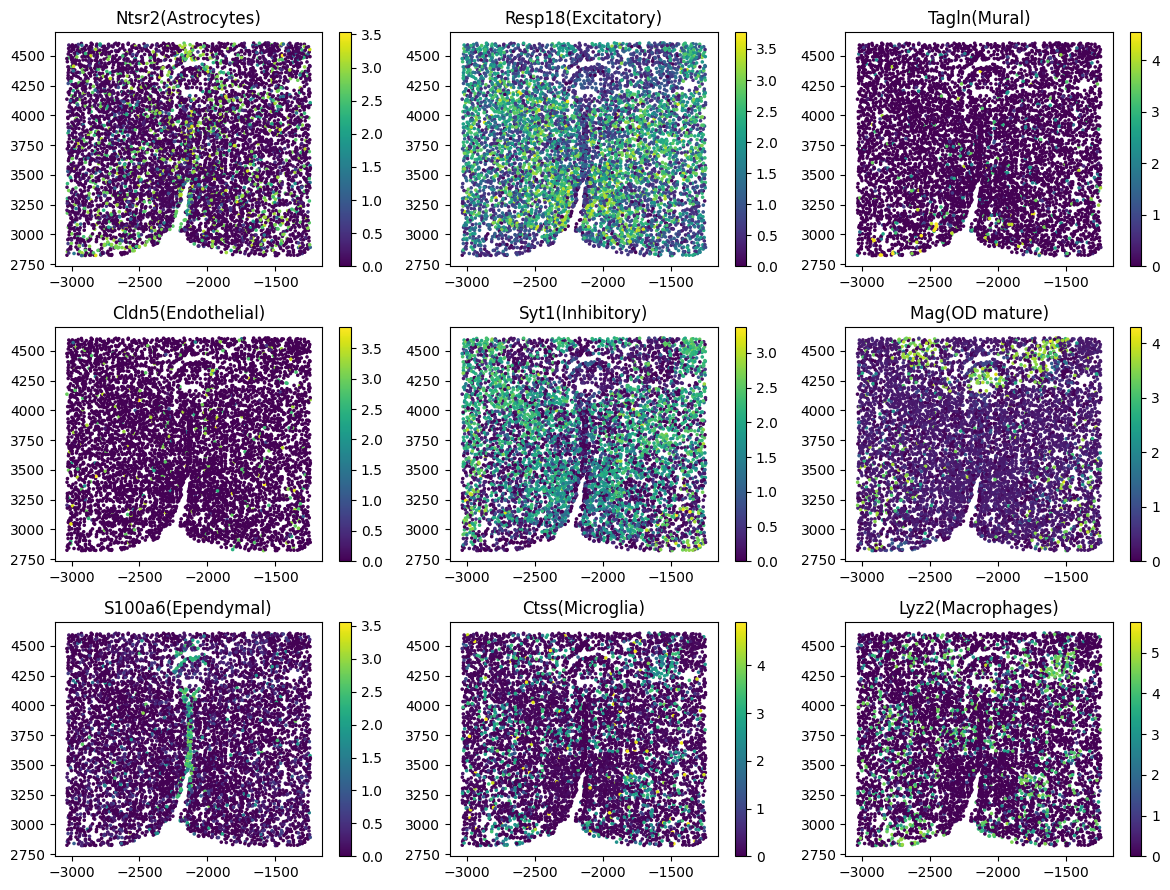

In [11]:
# The Bulk2Space predicted spatial expression of genes that not measured in MERFISH
# gene expression (Bulk2Space)
# Astrocytes (Ntsr2), Excitatory (Resp18), Mural (Tagln), Endothelial (Cldn5), Inhibitory (Syt1),
# OD mature (Mag), Ependymal (S100a6), Microglia (Ctss), Macrophages (Lyz2)

plot = df_meta
plot.index = list(plot['Cell'])
gene = ['Ntsr2', 'Resp18', 'Tagln', 'Cldn5', 'Syt1', 'Mag', 'S100a6', 'Ctss', 'Lyz2']
plot[gene] = df_data.T[gene]
xcoord = np.array(plot['xcoord'])
ycoord = np.array(plot['ycoord'])
gene1 = np.array(plot['Ntsr2'])
gene2 = np.array(plot['Resp18'])
gene3 = np.array(plot['Tagln'])
gene4 = np.array(plot['Cldn5'])
gene5 = np.array(plot['Syt1'])
gene6 = np.array(plot['Mag'])
gene7 = np.array(plot['S100a6'])
gene8 = np.array(plot['Ctss'])
gene9 = np.array(plot['Lyz2'])


# plot
fig, axs = plt.subplots(3, 3, figsize=(12, 9))

p1 = axs[0, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene1)
fig.colorbar(p1, ax=axs[0, 0])
axs[0, 0].set_title('Ntsr2(Astrocytes)')

p2 = axs[0, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene2)
fig.colorbar(p2, ax=axs[0, 1])
axs[0, 1].set_title('Resp18(Excitatory)')

p3 = axs[0, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene3)
fig.colorbar(p3, ax=axs[0, 2])
axs[0, 2].set_title('Tagln(Mural)')

p4 = axs[1, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene4)
fig.colorbar(p4, ax=axs[1, 0])
axs[1, 0].set_title('Cldn5(Endothelial)')

p5 = axs[1, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene5)
fig.colorbar(p5, ax=axs[1, 1])
axs[1, 1].set_title('Syt1(Inhibitory)')

p6 = axs[1, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene6)
fig.colorbar(p6, ax=axs[1, 2])
axs[1, 2].set_title('Mag(OD mature)')

p7 = axs[2, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene7)
fig.colorbar(p7, ax=axs[2, 0])
axs[2, 0].set_title('S100a6(Ependymal)')

p8 = axs[2, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene8)
fig.colorbar(p8, ax=axs[2, 1])
axs[2, 1].set_title('Ctss(Microglia)')

p9 = axs[2, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene9)
fig.colorbar(p9, ax=axs[2, 2])
axs[2, 2].set_title('Lyz2(Macrophages)')

plt.tight_layout()
plt.show()